## Step 1 : Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use('ggplot')

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.1.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 2 : Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print('Unique words in corpus:', data['Word'].nunique())
print('Unique tags in corpus:', data['Tag'].nunique())

Unique words in corpus: 35178
Unique tags in corpus: 17


In [4]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
num_words = len(words)

In [5]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)

## Step 3 : Retrieve Sentences and Corresponding Tags 

In [6]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s: [(w,p,t) for w,p,t in zip(s['Word'].values.tolist(), s['POS'].values.tolist(), s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

## Step 4 : Define Mappings between Sentences and Tags

In [9]:
word2idx = {w:i+1 for i,w in enumerate(words)}
tag2idx = {t:i for i,t in enumerate(tags)}

In [10]:
word2idx

{'ensuing': 1,
 'bless': 2,
 'uniformed': 3,
 'ninth-largest': 4,
 'clears': 5,
 'sixteen': 6,
 'Zebari': 7,
 'Sam': 8,
 'Each': 9,
 'Unopposed': 10,
 'migrant': 11,
 '81-year-old': 12,
 'Kariye': 13,
 'plastics': 14,
 'mainland': 15,
 'Marxism': 16,
 'fitted': 17,
 'Sudan': 18,
 'al-Muntadar': 19,
 'Normandy': 20,
 'crime': 21,
 'tidal': 22,
 'spat': 23,
 'Sainovic': 24,
 'net': 25,
 'auction': 26,
 '1936': 27,
 'Rodina': 28,
 'Binjie': 29,
 'internal': 30,
 'Miami-based': 31,
 'pursues': 32,
 'dismiss': 33,
 'enriching': 34,
 'Crab': 35,
 'tsunami': 36,
 'Widom': 37,
 'siphoning': 38,
 'fragility': 39,
 'Jordanian-American': 40,
 'no-balls': 41,
 'exemption': 42,
 'Agence': 43,
 'rescheduling': 44,
 'Zaraqawi': 45,
 'Jibla': 46,
 'Sylvester': 47,
 'court-approved': 48,
 'summary': 49,
 'Novosibirsk': 50,
 'Fradique': 51,
 'diplomat': 52,
 'underwater': 53,
 'Effectiveness': 54,
 'Blagojevic': 55,
 'reconcilation': 56,
 'followers': 57,
 'necessities': 58,
 'mistakenly': 59,
 'Columbi

In [11]:
tag2idx

{'B-art': 3,
 'B-eve': 8,
 'B-geo': 7,
 'B-gpe': 4,
 'B-nat': 2,
 'B-org': 13,
 'B-per': 14,
 'B-tim': 0,
 'I-art': 1,
 'I-eve': 10,
 'I-geo': 16,
 'I-gpe': 6,
 'I-nat': 11,
 'I-org': 12,
 'I-per': 9,
 'I-tim': 5,
 'O': 15}

## Step 5 : Padding Input Sentences and Creating Train-Test Splits

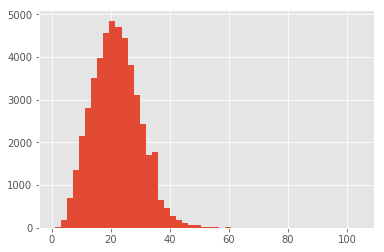

In [12]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [15]:
y_train = np.array(y_train)
y_test = np.array(y_test)

## Step 6 : Build and Compile a Bidirectional LSTM Model

In [16]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [17]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Step 7 : Train the Model

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKerasTF

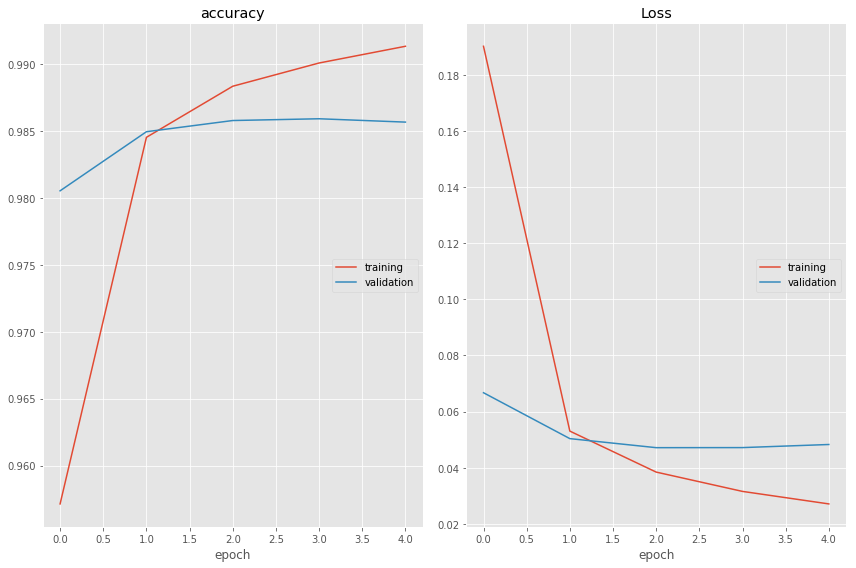

accuracy
	training         	 (min:    0.957, max:    0.991, cur:    0.991)
	validation       	 (min:    0.981, max:    0.986, cur:    0.986)
Loss
	training         	 (min:    0.027, max:    0.190, cur:    0.027)
	validation       	 (min:    0.047, max:    0.067, cur:    0.048)

Epoch 00005: val_loss did not improve from 0.04716
34530/34530 [==============================] - 282s 8ms/sample - loss: 0.0271 - accuracy: 0.9913 - val_loss: 0.0483 - val_accuracy: 0.9857
Wall time: 23min 12s


In [20]:
%%time

chkpt = ModelCheckpoint('model_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, mode='max')
callbacks = [PlotLossesKerasTF(), chkpt, early_stopping]

history = model.fit(x_train, y_train, validation_split=0.2, batch_size=32, epochs=100, verbose=1, callbacks=callbacks)

## Step 8 : Evaluate Named Entity Recognition Model

In [21]:
model.load_weights('model_weights.h5')

In [22]:
model.evaluate(x_test, y_test)

4796/4796 [==============================] - 6s 1ms/sample - loss: 0.0487 - accuracy: 0.9857


[0.04867874148664522, 0.9856756]

In [23]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(x_test[i].reshape(1,-1))
p = np.argmax(p, axis=-1)

y_actual = np.argmax(y_test[i], axis=-1)
print('{:15}{}\t{}'.format('Word', 'Actual', 'Pred'))
print('-'*30)
for w, actual, pred in zip(x_test[i], y_actual, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], tags[actual], tags[pred]))

Word           Actual	Pred
------------------------------
The            O	O
Sudanese       B-gpe	B-gpe
government     O	O
has            O	O
welcomed       O	O
the            O	O
Chinese        B-gpe	B-gpe
mission        O	O
to             O	O
Darfur         O	B-geo
.              O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded     O	O
unexploded